Kameron Lightheart

CS 312

## Temporal Complextiy:
Overall I found that my algorithm is of temporal complexity $O(n^2)$. This bound comes from the fact that I implemented a divide and conquer method that broke up a problem of size n into 2 subproblems each of size n/2 then to combine the subproblems was $O(n^2)$ as a worst case scenario. Note that this is rare because it would imply that the upper and/or lower common tanget loops run as many times as there are points in the given lists, which is nearly impossible even with a cooked up example. Keeping this upper bound, and applying the Master's Theorem with a=2,b=2 and d=2, we have that $d=2>1=log_ba \implies O(n^d) = O(n^2).$ See the code below for details on complexity of individual functions. The doc strings contain summary of temporal complexity and the bodies include the small details. 

## Spacial Complexity:
Overall I found that my algorithm is of spacial complexity $O(nm)$ where n is the length of the original list of points and m is the max recursion depth. See the code below for details on complexity of individual functions. The doc strings contain the details of the spacial complexity.

In [ ]:
from PyQt5.QtCore import QLineF, QPointF, QThread, pyqtSignal, QPoint
from PyQt5.QtGui import QPolygon



import time
import numpy as np

class ConvexHullSolverThread(QThread):
    def __init__( self, unsorted_points,demo):
        self.points = unsorted_points                    
        self.pause = demo
        QThread.__init__(self)

    def __del__(self):
        self.wait()

    # These two signals are used for interacting with the GUI.
    show_hull    = pyqtSignal(list,tuple)
    display_text = pyqtSignal(str)

    # Some additional thread signals you can implement and use for debugging,
    # if you like
    show_tangent = pyqtSignal(list,tuple)
    erase_hull = pyqtSignal(list)
    erase_tangent = pyqtSignal(list)
                    

    def set_points( self, unsorted_points, demo):
        self.points = unsorted_points
        self.demo   = demo

    def calc_slope(self, left, right):
        """
        Calculates the slope between two point in R2

        Temporal Complexity:
            3 operations => O(1)
            
        Spacial Complexity:
            None, doesn't save any values, simply returns

        Parameters:
            left (tuple) left point
            right (tuple) right point
        Returns: 
            slope (float) slope between the two points
        """
        return (left[1] - right[1]) / (left[0] - right[0])

    def combine_hulls(self, left, right, side, left_most, right_most):
        """
        Given a left and right convex hull, compute and return the 
        set of points that form a combined convex hull

        Temporal Complexity:
            O(p(n+m)) where p is max(n,m) (See comments below for details)

        Spacial Complextiy:
            3 + 7 (first while) + 3 + 7 (second while) + n+m+2 (result list)
            Thus total of n+m+22 = O(n+m)

        Parameters:
            left ((n,) list) list of left subhull ordered in counter-clockwise
                        orientation starting with the right most point
            right ((m,) list) list of right subhull ordered in clockwise
                        orientation starting with the left most point
            side (str) which side the two sublists came from, right left or 
                       None where None means it is the last combination
            left_most (int) index of the right most index (spacially) in 
                            the left list
            right_most (int) index of the left most index (spacialy) in 
                             the right list
        """
        upper_left = 0
        upper_right = 0
        updated = True

        # Worst case this while loop runs max(n, m) times if each hull is 
        # an arc i.e. O(n(n+m)) or O(m(n+m)) 
        while updated:
            # Worst case 5(n-1 + m-1) + 6 => O(n+m)
            updated = False

            # 3 operations in calc_slope
            left_slope = self.calc_slope(left[upper_left], right[upper_right])
            init_upper_left = upper_left

            # 5(n-1) => O(n)
            for i in range(init_upper_left+1, len(left)):
                # 3 operations in calc_slope
                left_new_slope = self.calc_slope(left[i], right[upper_right])

                # Max 2 operations 
                if left_new_slope > left_slope:
                    upper_left = i - 1
                    break
                else:
                    updated = True
                    upper_left = i
                    left_slope = left_new_slope

            # 3 operations in calc_slope
            right_slope = self.calc_slope(left[upper_left], right[upper_right])
            init_upper_right = upper_right

            # 5(m-1) => O(m)
            for i in range(init_upper_right+1, len(right)):
                # 3 operations in calc_slope
                right_new_slope = self.calc_slope(left[upper_left], right[i])

                # Max 2 operations
                if right_new_slope < right_slope:
                    upper_right = i - 1
                    break
                else:
                    updated = True
                    upper_right = i
                    right_slope = right_new_slope
        
        # Calculate lower common tangent
        lower_left = 0
        lower_right = 0
        updated = True

        # Same as last while loop => O(n(n+m)) or O(m(n+m)) 
        while updated:
            updated = False
            left_slope = self.calc_slope(left[-lower_left], right[-lower_right])
            init_lower_left = lower_left
            for i in range(init_lower_left+1, len(left)):
                left_new_slope = self.calc_slope(left[-i], right[-lower_right])
                if left_new_slope < left_slope:
                    lower_left = i - 1
                    break
                else:
                    updated = True
                    lower_left = i
                    left_slope = left_new_slope
            
            right_slope = self.calc_slope(left[-lower_left], right[-lower_right])
            init_lower_right = lower_right
            for i in range(init_lower_right+1, len(right)):
                right_new_slope = self.calc_slope(left[-lower_left], right[-i])
                if right_new_slope > right_slope:
                    lower_right = i - 1
                    break
                else:
                    updated = True
                    lower_right = i
                    right_slope = right_new_slope

        # Since lower tangents are found in the backwards orientation, adjust 
        # them back to the index in the correct orientation
        # Max of 4 operations
        if lower_left != 0:
            lower_left = len(left) - lower_left
        if lower_right != 0:
            lower_right = len(right) - lower_right

        # Sort right hulls clockwise, left counter-clockwise
        result = []
        # Total temportal complexity for the right side is
        # n+m+n+m+n = 3n + 2m => O(n+m)
        if side == "r":
            # list.extend is O(k) where k are number of elements added
            # thus worst case senario is O(n+m)
            # Reversing the lists ([::-1]) is also O(k) and is worst case
            # Applied to the whole left hull, this O(n)
            result.extend(left[upper_left:left_most+1][::-1])
            if upper_right > lower_right:
                result.extend(right[upper_right:])
                result.extend(right[:lower_right+1])
            else:    
                result.extend(right[upper_right:lower_right+1])

            # Index function is O(l) (l is length of result at this point)
            # Worst case is O(n+m) if all of left and right are in result
            new_right_most = result.index(right[right_most])
            
            if lower_left != left_most:
                if lower_left > upper_left:
                    result.extend(left[left_most+1:lower_left+1][::-1])
                else:
                    result.extend(left[:lower_left+1][::-1])
                    result.extend(left[left_most+1:][::-1])
        # Temporal complexity of left sides is 3m + 2n = O(m+n) similarly
        # If side is None, default to counter-clockwise
        else:
            result.extend(right[upper_right:right_most+1][::-1])
            if upper_left > lower_left: 
                result.extend(left[upper_left:])
                result.extend(left[:lower_left+1][::-1])
            else:
                result.extend(left[upper_left:lower_left+1])

            new_left_most = result.index(left[left_most])

            if lower_right != right_most:
                if lower_right > upper_right:
                    result.extend(right[right_most+1:lower_right+1][::-1])
                else:
                    result.extend(right[:lower_right+1][::-1])
                    result.extend(right[right_most+1:][::-1])
        if side == "r":
            return result, new_right_most
        else:
            return result, new_left_most

    def recursive_hull(self, sublist, side):
            """
            Function that recursively divides the problem into 2 sides

            Temporal Complexity:
                Divides problem into 2 subproblems of size (n)/2 with O(n^2). 
                Assuming without loss of generality that p = n, by the Master's 
                Theorem with a=2, b=2 and d=2 we have O(n^2).

            Spacial Complexity:
                1 + 1 + n/2 + n/2 + 2 + n/2 + n/2 + n (combine hulls call) => 
                O(n) spacial complexity for each call. 

            Parameters:
                sublist (list) list of points 
                side (str) "l" or "r" side points are on, left are ordered
                           counter-clockwise from right most point, right 
                           are ordered clockwise from left most point
            """
            m = len(sublist)
            # Base case
            # Order left list counter-clockwise from right most
            if  side == "l":
                if m == 2:
                    return sublist[::-1], 1
                elif m == 3:
                    first_slope = self.calc_slope(sublist[0], sublist[1])
                    second_slope = self.calc_slope(sublist[0], sublist[2])
                    if first_slope > second_slope:
                        return sublist[::-1], 2
                    else:
                        return [sublist[2], sublist[0], sublist[1]], 1
            else: # Order right list clockwise from left most
                if m == 2:
                    return sublist, 1
                elif m == 3:
                    first_slope = self.calc_slope(sublist[0], sublist[1])
                    second_slope = self.calc_slope(sublist[0], sublist[2])
                    if first_slope > second_slope:
                        return sublist, 2
                    else:
                        return [sublist[0], sublist[2], sublist[1]], 1

            mid = m // 2
            left, right = sublist[:mid], sublist[mid:]
            l_hull, left_most = self.recursive_hull(left, "l") 
            r_hull, right_most = self.recursive_hull(right, "r")
            
            return self.combine_hulls(l_hull, r_hull, side, left_most, right_most)

    def run(self):
        """
        Temporal Complexity:
            O(n) for converting QPoints to tuples in list, O(n) for sorting the list,
            O(n^2) for both resursive calls (see function docstring for details), 
            plus O(n^2) for combine_hulls call thus total of O(n^2).
        
        Spacial Complexity:
            5 + n (points_list) + 3 + 2*n*m (recursive calls each are O(n), assume m
            recursive depth) + O(n) (combine_hulls) + O(n) (polygon). In total this is
            O(n*m) for spacial complexity. 
        """
        assert( type(self.points) == list and type(self.points[0]) == QPointF )

        n = len(self.points)
        print( 'Computing Hull for set of {} points'.format(n) )

        t1 = time.time()
        # TODO: SORT THE POINTS BY INCREASING X-VALUE
        points_list = [(point.x(), point.y()) for point in self.points]
        points_list = sorted(points_list, key=lambda x: x[0])
        t2 = time.time()
        print('Time Elapsed (Sorting): {:3.3f} sec'.format(t2-t1))

        t3 = time.time()
        # TODO: COMPUTE THE CONVEX HULL USING DIVIDE AND CONQUER
        if len(points_list) < 4:
            convex_hull = points_list
        else:
            mid = len(points_list) // 2
            left, right = points_list[:mid], points_list[mid:]
            left, left_most = self.recursive_hull(left, "l")
            right, right_most = self.recursive_hull(right, "r")

            convex_hull, _ = self.combine_hulls(left, right, None, left_most,\
                                                right_most)            
        t4 = time.time()

        polygon = [QLineF(QPointF(convex_hull[i][0], convex_hull[i][1]),\
                   QPointF(convex_hull[i+1][0], convex_hull[i+1][1]))\
                                 for i in range(-1, len(convex_hull) - 1)]
        assert( type(polygon) == list and type(polygon[0]) == QLineF )
        self.show_hull.emit(polygon, (0,255,0))

            
        # Send a signal to the GUI thread with the time used to compute the 
        # hull
        self.display_text.emit('Time Elapsed (Convex Hull): {:3.3f} sec'\
                                                           .format(t4-t3))
        print('Time Elapsed (Convex Hull): {:3.3f} sec'.format(t4-t3))

## Experimental Outcomes
Here are the list of mean times and all times. The mean times list includes the average time it took to run the convex hull algorithm for each number of points in {10, 100, 1_000, 10_000, 100_000, 500_000, 1_000_000}. Note that there are values of n that seperate the actual times to distinguish between the times for each n value.

In [5]:
mean_times = [0.0001968860626220703, 0.001258707046508789, 0.017820358276367188, 0.1706336498260498, 1.2259047508239747, 10.004690647125244, 14.518516731262206]
all_times = [10, 0.0, 0.0, 0.0009844303131103516, 0.0, 0.0, 100, 0.0019791126251220703, 0.001995086669921875, 0.0008394718170166016, 0.0009984970092773438, 0.0004813671112060547, 1000, 0.016954898834228516, 0.0159604549407959, 0.0208284854888916, 0.018949031829833984, 0.016408920288085938, 10000, 0.14270853996276855, 0.2094404697418213, 0.19200921058654785, 0.1630406379699707, 0.14596939086914062, 100000, 1.74342942237854, 1.3158085346221924, 1.04380464553833, 1.0660128593444824, 0.9604682922363281, 500000, 6.657456874847412, 11.963441848754883, 14.251884460449219, 9.918757200241089, 7.231912851333618, 1000000, 14.82498550415039, 14.506629467010498, 14.086594343185425, 14.663586378097534, 14.510787963867188]

Plotting the number of points against time it takes using a logarithmic scale for the values of n suggests that the complexity grows exponentially as you increase by multiples of 10, but the normal plot suggests that the algorithm has a more linear complexity. This is interesting because my initial computations of temporal complexity suggested a potential quadratic growth in time. This can again be explained by the fact that $O(n^2)$ is a steep upper bound for the complexity of the combine_hulls function. If we assumed a linear complexity for that function, then we would have 2 subproblems of size n/2 combined in O(n) time which would mean O(nlogn) by the Master's Theorem. Thus we will compute the constants of proportionality to k*nlogn in our analysis.

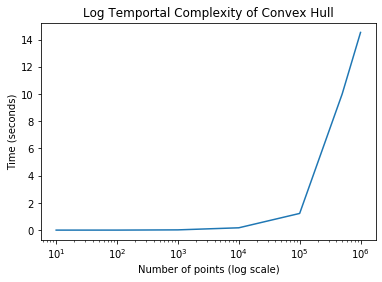

In [20]:
from matplotlib import pyplot as plt
import numpy as np
ns = [10, 100, 1_000, 10_000, 100_000, 500_000, 1_000_000]
plt.plot(ns, mean_times)
plt.xscale("log")
plt.title("Log Temportal Complexity of Convex Hull")
plt.xlabel("Number of points (log scale)")
plt.ylabel("Time (seconds)")
plt.show()

Text(0, 0.5, 'Time (seconds)')

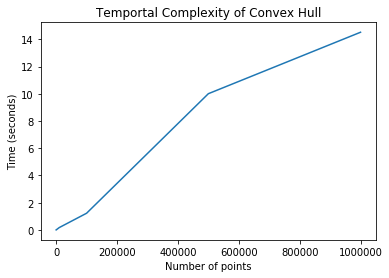

In [22]:
plt.plot(ns, mean_times)
plt.title("Temportal Complexity of Convex Hull")
plt.xlabel("Number of points")
plt.ylabel("Time (seconds)")

## Constant of Proportionality
To compute the constant of proportionality, first we assume complexity of O(nlogn) as explained above. Next for each value of n points, we set the mean time taken for those n points to compute the convex hull equal to a constant k times nlogn and solve for k. In other words $t=knlogn\implies k=\frac{t}{(nlogn)}$

In [12]:
for i,n in enumerate(ns):
    k = mean_times[i] / (n*np.log(n))
    print("Constant of proportionality for n={} is {}".format(n, k))

Constant of proportionality for n=10 is 8.55065305604232e-06
Constant of proportionality for n=100 is 2.7332476231575337e-06
Constant of proportionality for n=1000 is 2.579761088321738e-06
Constant of proportionality for n=10000 is 1.85263131366163e-06
Constant of proportionality for n=100000 is 1.0648073372436662e-06
Constant of proportionality for n=500000 is 1.5248306054917714e-06
Constant of proportionality for n=1000000 is 1.0508852836345357e-06
